In [1]:

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

TensorFlow version: 2.19.0
Keras version: 3.11.1


In [3]:
# dataset directory
dataset_dir = "dataset-allin/sorted"

# load and preprocess the dataset
data = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),  # Resize to match ResNet50 input
    batch_size=32,
    shuffle=True
)

# split the dataset into train, validation, and test sets
def split_dataset(dataset, train_size=0.7, val_size=0.2):
    total_size = dataset.cardinality().numpy()
    train_dataset = dataset.take(int(total_size * train_size))
    val_test_dataset = dataset.skip(int(total_size * train_size))
    val_dataset = val_test_dataset.take(int(total_size * val_size))
    test_dataset = val_test_dataset.skip(int(total_size * val_size))
    return train_dataset, val_dataset, test_dataset

train, val, test = split_dataset(data)

# prefetch for performance
train = train.prefetch(tf.data.AUTOTUNE)
val = val.prefetch(tf.data.AUTOTUNE)
test = test.prefetch(tf.data.AUTOTUNE)

Found 1839 files belonging to 3 classes.


In [4]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1)
])
train = train.map(lambda x, y: (data_augmentation(x), y))

# load the ResNet50 model without the top layer
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model


In [5]:
# build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Global pooling layer
    Dense(512, activation='relu'),  # Dense layer for feature extraction
    Dropout(0.5),  # Dropout for regularization
    Dense(3, activation='softmax')  # 3 classes: first, second, and third-degree burns
])

# compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)


In [6]:
# train the model
history = model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5078 - loss: 1.4314 - val_accuracy: 0.6250 - val_loss: 0.8255 - learning_rate: 0.0010
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.6125 - loss: 0.8223 - val_accuracy: 0.6761 - val_loss: 0.7142 - learning_rate: 0.0010
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6672 - loss: 0.7532 - val_accuracy: 0.6648 - val_loss: 0.7316 - learning_rate: 0.0010
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6805 - loss: 0.6916 - val_accuracy: 0.6222 - val_loss: 0.8859 - learning_rate: 0.0010
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7039 - loss: 0.6653 - val_accuracy: 0.7528 - val_loss: 0.5697 - learning_rate: 0.0010
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7312 - loss: 0.6289 - val_accuracy: 0.7273 - val_loss: 0.5920 - learning_rate: 0.0010
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7188 - loss: 0.6089 - val_accuracy: 

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7437 - loss: 0.6050 - val_accuracy: 0.7415 - val_loss: 0.6225 - learning_rate: 5.0000e-04
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7398 - loss: 0.5839 - val_accuracy: 0.7358 - val_loss: 0.5730 - learning_rate: 5.0000e-04
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7883 - loss: 0.5231 - val_accuracy: 0.7358 - val_loss: 0.6014 - learning_rate: 5.0000e-04
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7773 - loss: 0.5108 - val_accuracy: 0.7273 - val_loss: 0.6310 - learning_rate: 2.5000e-04
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7867 - loss: 0.4971 - val_accuracy: 0.7472 - val_loss: 0.5597 - learning_rate: 2.5000e-04
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8117 - loss: 0.4707 - val_accuracy: 0.7528 - val_loss: 0.5627 - learning_rate: 2.5000e-04
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8023 - loss:

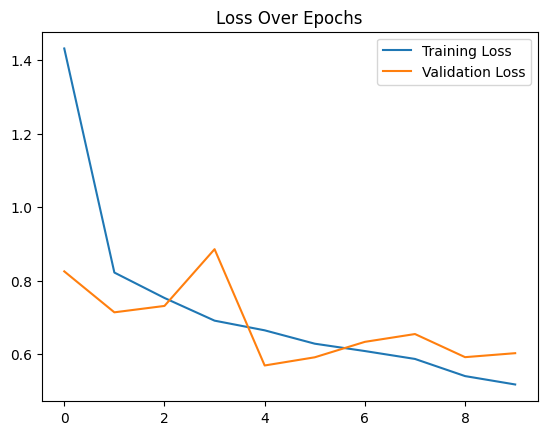

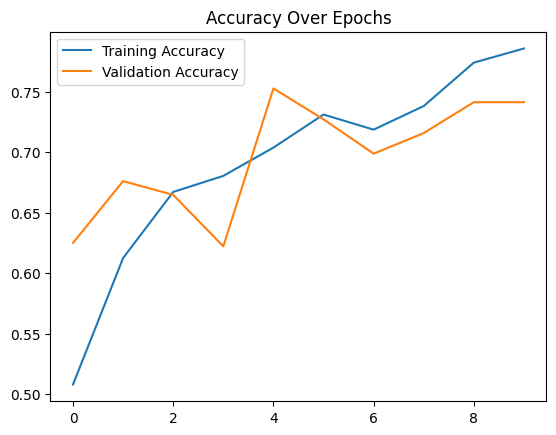

In [7]:
history_finetune = model.fit(
    train,
    validation_data=val,
    epochs=10,  # Fine-tune for a few more epochs
    callbacks=[early_stopping, reduce_lr]
)

# evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# plot training history
import matplotlib.pyplot as plt

# plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

In [9]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import numpy as np

# initialize metrics
pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision: 0.8321
Recall: 0.8583
Accuracy: 0.7391


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


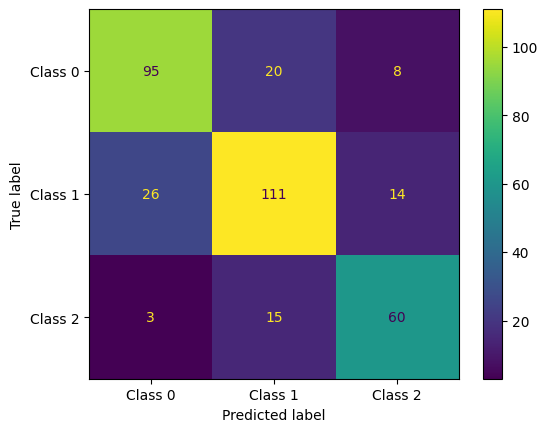

In [10]:
#Debug Learning Progress
#Plot the confusion matrix for the validation set to identify misclassified classes


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []
for images, labels in val:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1', 'Class 2'])
disp.plot()